# **Stock market prediction 📈**
Stock market prediction is the act of trying to determine the future value of a company stock or other financial instrument traded on an exchange. The successful prediction of a stock's future price could yield significant profit.

Using machine learning techniques I will try to 

* predict the stock value of more than 700 companies over a period of 20 years
* predict the stock value of more than 1200 companies over a period of 5 years, also using financial indicators

After having trained the models (linear regression and random forest regression), I will test them during the COVID crisis period, a major financial crisis in which even the best stock lost value, and see how they perform in comparison to a normal period. 
Finally I will try to train a neural network, and see how it compares with more linear methods.  

This notebook is divided in the following way:


1.   Configuring the environment: in this paragraph dependencies and pyspark are installed, also the configuration of how the rest of the notebook will be run is set, so make sure to check it in order to personalise your experience using this notebook.
2.   Building the datasets: here the datasets that will be later used for the training of the models are created
3.  Exploring the datasets: using Colab's tools you can visualize the datasets, and see useful insight
4. Features engineering: we can't feed to the model the dataset as it is. We must create features that are useful for our prediction task.
5. Learning pipeline: in this step the actual training is done, several models are available, so that we can see which performs better
6. Hyperparameters tuning: using the appropriate hyperparameters can significally improve the performance of our models, so we try many of them and choose the best one
7. Testing the models: we choose a period and test how the model would have predicted that period
8. Plotting results: here we visualize the results of the predictions 
9. Conclusion: the project is over, what have we learned?


In order to correctly execute the notebook, follow each step sequentially, because each step depend on the previous one. 



## Configuring the environment 
Have a look at this paragraph in order to correctly configure the execution of the notebook.

**Setting global variables**

- Please set LOCAL to true if you are working offline on your machine (default is false, so the code will run on Google servers)

- Please set DOWNLOAD to false if you want to create from scratch the datasets (in this way they will be updated with the most up to date data but beware, the creation of the dataset takes a lot of time) otherwise the datasets will be downloaded from my github.

In [1]:
"""
set to true if you want to work on your hardware (pyspark and other dependencies required)
set to false if you want to work on colab server and use your google drive
"""
LOCAL = False #@param {type:"boolean"}

"""
set to true if you want to use an old version (faster)
set to false if you want to recreate the datasets from scratch (newer data)
"""
DOWNLOAD = True #@param {type:"boolean"}


SEED = 42

**Installing pyspark**

If you are *not* working on google servers, please make sure to have already installed all the dependencies imported here.

In [ ]:
if (not LOCAL): 
  JAVA_HOME = "/usr/lib/jvm/java-8-openjdk-amd64"
  !pip install pyspark
  !pip install -U -q PyDrive
  !apt-get update
  !apt install openjdk-8-jdk-headless -qq
  import os
  os.environ["JAVA_HOME"] = JAVA_HOME

import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf
from pyspark.sql.functions import col
from pyspark.sql import functions as func
from pyspark.ml.regression import LinearRegressionModel
from pyspark.ml.regression import RandomForestRegressionModel
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import percent_rank
from pyspark.sql import Window
from pyspark.ml.feature import Normalizer
from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.pipeline import Pipeline, PipelineModel

# Create the session
conf = SparkConf().set("spark.ui.port", "4050").set('spark.executor.memory', '4G').set('spark.driver.memory', '45G').set('spark.driver.maxResultSize', '10G')

# Create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.appName("StockPredictions").getOrCreate()


**Import dependencies**

Here are some other dependencies that you must have already installed if you are working on your personal machine


In [3]:
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import requests
import numpy as np
from pandas.io.json import json_normalize
import time   
import os
import datetime
import shutil
import zipfile
import math
import urllib.request 
from random import *

**Installing sparktorch and dependencies**

In [ ]:
if (not LOCAL): 
  !pip install sparktorch
  !pip3 install torch torchvision

from sparktorch import serialize_torch_obj, SparkTorch 
import torch
import torch.nn as nn
from sparktorch import PysparkPipelineWrapper
from pyspark.ml.pipeline import PipelineModel


**Linking google drive to working directory**

This step will create a "Big_Data_stock_prediction" directory either on your machine (if LOCAL is true) or on your google drive. Make sure to have enough space (at least 1GB) 

In [ ]:
HOME_DIR = ""
if (LOCAL):
  HOME_DIR = os.getcwd() + "/Big_Data_stock_prediction"
else:
  GDRIVE_DIR = "/content/gdrive" # Your own mount point on Google Drive
  GDRIVE_HOME_DIR = GDRIVE_DIR + "/My Drive" # Your own home directory
  HOME_DIR = GDRIVE_HOME_DIR + "/Big_Data_stock_prediction" # Your own data directory

  from google.colab import drive
  drive.mount(GDRIVE_DIR, force_remount=True)

try: 
  os.mkdir(HOME_DIR) #the folder Big_Data_stock_prediction is either created or already exists
except: 
  print("Folder Big_Data already exists") 

## Building the datasets
Data is fundamental in machine learning, so it's crucial to retrieve the dataset that will be used for training our models. 
Stock market data can be found for free but with some limitations, so it's important to create ways to cope with them.
I mixed data from [Yahoo Finance](https://it.finance.yahoo.com/) and [Alpha Vantage](https://www.alphavantage.co/) to increment the features of our dataset.

Multiple datasets will be created in each subsection:
- Simple dataset: 5646 rows, 5 attributes for 783 stocks
- Medium dataset: 1012 rows (or more), 15 attributes for 1218 stocks
- Intraday dataset: 360 rows (or more), 5 attributes for 1359 stocks

First, the best stocks were selected using the [Nasdaq screener](https://www.nasdaq.com/market-activity/stocks/screener), selecting the following filters:
- Market Cap > $2B
- Analyst rated as Strong buy or Hold
- Country: United States

This filter are applied for the [NYSE](https://www.nyse.com/index) and [NASDAQ](https://www.nasdaq.com/) stocks.

This procedure is useful because we can quickly discard the stocks that are not interesting, and focus on the most prominent, the ones that get more attention and most importantly are more traded. 

Unfortunately Nasdaq does not provide API's so I downloaded the resulting csv on my GitHub, but since companies with a market cap this huge are not created every day, I think it will be sufficient to update this file every year.

In [6]:
NASDAQ_LINK = "https://raw.githubusercontent.com/itsbenigno/stock_market_predictions/main/Symbols/best%20of%20NASDAQ.csv"
NYSE_LINK = "https://raw.githubusercontent.com/itsbenigno/stock_market_predictions/main/Symbols/best%20of%20NYSE.csv"

nasdaq_symbols = pd.read_csv(NASDAQ_LINK)["Symbol"] #csv of the best NASDAQ symbols
nyse_symbols = pd.read_csv(NYSE_LINK)["Symbol"] #csv of the best NYSE symbols
stock_symbols = [stock for stock in nasdaq_symbols] #list of the best NASDAQ symbols
stock_symbols += [stock for stock in nyse_symbols] #list of the best NYSE symbols

stock_symbols = sorted(list(set(stock_symbols))) #list of the best NASDAQ and NYSE symbols

###Creating a simple dataset
We will start by creating for each company, the stock price of it for circa 20 years. We want to start easy, and then increment the dataset, to see if financial features are actually useful for this kind of task.

I will use Yahoo to retrieve the data, and select only the symbols which have more than 4000 rows available (each year has 253 days circa).
Some symbols are not available using Yahoo, but since this API has no limitation in the number of requests and we want to build the simple database quickly, we will go for it. 
The data that Yahoo will let us download for free are:
- *Open*: price of the stock at the beginning of the financial day
- *Close*: price of the stock at the end of the financial day
- *High*: is the highest price at which a stock is traded during the financial day
- *Low*: is the lowest price at which a stock is traded during the financial day
- *Volume*: the total number of shares exchanged during the financial day


In [7]:
START = int(time.mktime((2000, 1, 1, 0, 0, 0, 0, 0, 0))) #1 january 2000
END = int(time.time()) # today
DATA_TRESHOLD = 253*20 #more than 20 years worth of data

#return the Yahoo daily data of a stock from start to end
# the schema will be -> |Date|Open|High|Low|Close|Volume|
def get_daily_yahoo(symbol, start, end):
  URL = "https://query1.finance.yahoo.com/v7/finance/download/{symbol}?period1={start_seconds_from_epoch}&period2={end_seconds_from_epoch}&interval=1d&events=history&includeAdjustedClose=true"
  URL_personalised = URL.format(symbol=symbol, start_seconds_from_epoch = start, end_seconds_from_epoch = end)
  daily_stock_data = spark.createDataFrame(pd.read_csv(URL_personalised)) 
  daily_stock_data = daily_stock_data.withColumn('Date', to_date(col("Date"),"yyyy-MM-dd")) #changing Date column type to "data"
  daily_stock_data = daily_stock_data.drop("Adj Close") #redundant for our scope
  return daily_stock_data

#creates the first dataset, and save it on the folder Dataset_simple
def create_dataset_simple():
  available = 0
  
  if (not os.path.exists(HOME_DIR+"/Dataset_simple")):   
      os.mkdir(HOME_DIR+"/Dataset_simple") 
      
  for symbol in stock_symbols:

    if (not os.path.exists(HOME_DIR+"/Dataset_simple/"+symbol+".csv")):
      df = None
      try: 
        df = get_daily_yahoo(symbol, START, END) 
      except: #some stocks are marked as "private" by yahoo
        print(symbol, " not available using Yahoo")
        
      if (df != None and df.count() > DATA_TRESHOLD): #save if there's enough data
        df.toPandas().to_csv(HOME_DIR+"/Dataset_simple/"+symbol+".csv")
        available += 1
      else:
        print(symbol, " does not have sufficient data")

  print(available, " symbols data over ", len(stock_symbols), " available downloaded")

#compress the dataset made of multiple datasets to have a simple zip file
def compress_dataset_simple():
  if (not os.path.exists(HOME_DIR+"/Dataset_simple_compressed")):
    shutil.make_archive(HOME_DIR+"/Dataset_simple_compressed", 'zip', HOME_DIR+"/Dataset_simple")
    
if (not DOWNLOAD): #create dataset from scratch
  create_dataset_simple()
  compress_dataset_simple()
else: #downloading zip dataset from github (and uncompressing on the current folder)
  print("Downloading dataset from GitHub")
  DATASET_LINK = "https://github.com/itsbenigno/stock_market_predictions/raw/main/Dataset_simple_compressed.zip"
  urllib.request.urlretrieve(DATASET_LINK, HOME_DIR+"/Dataset_simple_compressed.zip")
  with zipfile.ZipFile(HOME_DIR+"/Dataset_simple_compressed.zip", 'r') as zip_ref:
    zip_ref.extractall(HOME_DIR+"/Dataset_simple")


###Experimenting with additional features: exploiting financial indicators 

The previous dataset is a pretty common for this kind of task.
I want to try something, not very often seen, and use Alphavantage to create a dataset containing for each company also its financial indicators.
Of course the stock price of a company doesn't always depend on how well the company is doing, so we'll see if this kind of data is really useful.

Financial data is provided by quarterly reports (4 times every year), the idea is to build a dataset in which for each day, as well as the standard price attributes there are also the financial indicators of that quarter. 

To do that I have to merge the dataset of the price, with the financial indicators. 
AlphaVantage offers financial data starting from 2017, so the dataset will start from there.
I'm using a free API that has a maximum number of requests per minute, so I must take this into account. 


In [ ]:
START = int(time.mktime((2017, 6, 31, 0, 0, 0, 0, 0, 0)))
DATA_TRESHOLD = 253*4
#API_KEY = "Z48JSG64FO6U83HL" 
API_KEY = "N53XWZB9IRAA0TXD"

#return a dataframe with this schema, annualy and quarterly
# |fiscalDateEnding|ebit|ebitda|netIncome|researchAndDevelopment|
def get_income_statement(symbol):
  URL = "https://www.alphavantage.co/query?function=INCOME_STATEMENT&symbol={symbol}&outputsize=full&apikey={apikey}"  
  URL_personalised = URL.format(symbol=symbol, apikey=API_KEY)
  r = requests.get(URL_personalised)
  try:
    data = r.json()
  except:
   return None
  if (len(data) <= 1):
    print(symbol, " not available, too many requests")
    return None
  #alphavantage returns a json, we have to transform it into a csv
  df = pd.json_normalize(data['annualReports'])
  df1 = pd.json_normalize(data['quarterlyReports'])
  income_statement_ann = spark.createDataFrame(df).withColumn('fiscalDateEnding', to_date(col("fiscalDateEnding"),"yyyy-MM-dd"))
  income_statement_ann = income_statement_ann.select(col("fiscalDateEnding"),col("ebit"), col("ebitda"), col("netIncome"), col("researchAndDevelopment"))
  income_statement_qrt = spark.createDataFrame(df1).withColumn('fiscalDateEnding', to_date(col("fiscalDateEnding"),"yyyy-MM-dd"))
  income_statement_qrt = income_statement_qrt.select(col("fiscalDateEnding"),col("ebit"), col("ebitda"), col("netIncome"), col("researchAndDevelopment"))

  return income_statement_ann, income_statement_qrt

#return a dataframe with this schema, annualy and quarterly
# |fiscalDateEnding|totalCurrentAssets|totalCurrentLiabilities|
def get_balance_sheet(symbol):
  URL = "https://www.alphavantage.co/query?function=BALANCE_SHEET&symbol={symbol}&apikey={apikey}"  
  URL_personalised = URL.format(symbol=symbol, apikey=API_KEY)
  r = requests.get(URL_personalised)
  try:
    data = r.json()
  except:
   return None
  if (len(data) <= 1):
    print(symbol, " not available, too many requests")
    return None
  df = pd.json_normalize(data['annualReports'])
  df1 = pd.json_normalize(data['quarterlyReports'])
  balance_sheet_ann = spark.createDataFrame(df).withColumn('fiscalDateEnding', to_date(col("fiscalDateEnding"),"yyyy-MM-dd"))
  balance_sheet_ann = balance_sheet_ann.select(col("fiscalDateEnding"), col("totalCurrentAssets"), col("totalCurrentLiabilities"))
  balance_sheet_qrt = spark.createDataFrame(df1).withColumn('fiscalDateEnding', to_date(col("fiscalDateEnding"),"yyyy-MM-dd"))
  balance_sheet_qrt = balance_sheet_qrt.select(col("fiscalDateEnding"), col("totalCurrentAssets"), col("totalCurrentLiabilities"))
  return balance_sheet_ann, balance_sheet_qrt

#return a dataframe with this schema, annualy and quarterly
# |fiscalDateEnding|dividendPayout|operatingCashflow|
def get_cash_flow(symbol):
  URL = "https://www.alphavantage.co/query?function=CASH_FLOW&symbol={symbol}&apikey={apikey}"  
  URL_personalised = URL.format(symbol=symbol, apikey=API_KEY)
  r = requests.get(URL_personalised)
  try:
    data = r.json()
  except:
   return None
  if (len(data) <= 1):
    print(symbol, " not available, too many requests")    
    return None
  df = pd.json_normalize(data['annualReports'])
  df1 = pd.json_normalize(data['quarterlyReports'])
  cash_flow_ann = spark.createDataFrame(df).withColumn('fiscalDateEnding', to_date(col("fiscalDateEnding"),"yyyy-MM-dd"))
  cash_flow_ann = cash_flow_ann.select(col("fiscalDateEnding"), col("dividendPayout"), col("operatingCashflow"))
  cash_flow_qrt = spark.createDataFrame(df1).withColumn('fiscalDateEnding', to_date(col("fiscalDateEnding"),"yyyy-MM-dd"))
  cash_flow_qrt = cash_flow_qrt.select(col("fiscalDateEnding"), col("dividendPayout"), col("operatingCashflow"))
  return cash_flow_ann, cash_flow_qrt

#return a dataframe with this schema, annualy and quarterly
# |fiscalDateEnding|reportedEPS|surprisePercentage|
def get_earnings(symbol):
  URL = "https://www.alphavantage.co/query?function=EARNINGS&symbol={symbol}&apikey={apikey}"  
  URL_personalised = URL.format(symbol=symbol, apikey=API_KEY)
  r = requests.get(URL_personalised)
  try:
    data = r.json()
  except:
   return None
  if (len(data) <= 1):
    print(symbol, " not available, too many requests")    
    return None
  df = pd.json_normalize(data['annualEarnings'])
  df1 = pd.json_normalize(data['quarterlyEarnings'])
  earnings_ann = spark.createDataFrame(df).withColumn('fiscalDateEnding', to_date(col("fiscalDateEnding"),"yyyy-MM-dd"))
  earnings_ann = earnings_ann.select(col("fiscalDateEnding"), col("reportedEPS"))
  earnings_qrt = spark.createDataFrame(df1).withColumn('fiscalDateEnding', to_date(col("fiscalDateEnding"),"yyyy-MM-dd"))
  earnings_qrt = earnings_qrt.select(col("fiscalDateEnding"), col("reportedEPS"), col("surprisePercentage"))
  return earnings_ann, earnings_qrt

#print all possible attributes of alphavantage
def print_financial_columns():
  print(get_income_statement("AAPL")[1].columns)
  print(get_balance_sheet("AAPL")[1].columns)
  print(get_cash_flow("AAPL")[1].columns)
  print(get_earnings("AAPL")[1].columns)


#given the timeseries of stock price, merges the dataset with other
#financial attributes
def merge_price_with_data(original_df, new_data_df, interval):
  #add the new dataframe columns to original dataframe 
  for column in new_data_df.columns[1:]:
    column_interval = "".join(str(column + "_" + interval).split())
    original_df = original_df.withColumn(column_interval,lit("Null")) 
  print("Created new columns")
  new_data_list = new_data_df.collect() #list all the rows of the new dataset

  for row in new_data_list:
    end = ""
    start = ""
    if interval == "ann":
      end = row["fiscalDateEnding"] + datetime.timedelta(365)
      start = end - datetime.timedelta(365)
    elif interval == "qrt":
      end = row["fiscalDateEnding"] + datetime.timedelta(91)
      start = end - datetime.timedelta(91) 

    for column in new_data_df.columns[1:]: 
      column_interval = "".join(str(column + "_" + interval).split())
      original_df = original_df.withColumn(column_interval, when((func.col('Date')<=end) & (func.col('Date')>=start), row[column]).otherwise(func.col(column_interval)))
      print("Added new columns to original df")
  return original_df


#get the interday database, and merge it with all financial attributes of alphavantage
def get_symbol_interday_complete_df(symbol, start, end, data_treshold):
  try:
    df = get_daily_yahoo(symbol, start, end)
  except:
    print(symbol, " not available from Yahoo")
    return None
  #financial_attributes_ann = []
  financial_attributes_qrt = []

  if (df.count() > data_treshold):
    income = get_income_statement(symbol)
    income_ann, income_qrt = income if income != None else (None,None)
    #financial_attributes_ann.append(income_ann)
    financial_attributes_qrt.append(income_qrt)

    balance = get_balance_sheet(symbol)
    balance_ann, balance_qrt = balance if balance != None else (None,None)
    #financial_attributes_ann.append(balance_ann)
    financial_attributes_qrt.append(balance_qrt)

    cash_flow = get_cash_flow(symbol)
    cash_flow_ann, cash_flow_qrt = cash_flow if cash_flow != None else (None,None)
    #financial_attributes_ann.append(cash_flow_ann)
    financial_attributes_qrt.append(cash_flow_qrt)

    earnings = get_earnings(symbol)
    earnings_ann, earnings_qrt = earnings if earnings != None else (None, None)
    #financial_attributes_ann.append(earnings_ann)
    financial_attributes_qrt.append(earnings_qrt)
  else: 
    print("not enough data for ", symbol)
    return None

  for attribute_df in financial_attributes_qrt:
    if (attribute_df == None):
      return None
    df = merge_price_with_data(df, attribute_df, "qrt")

  return df

#create a folder in which saves the datasets of all symbols, obtained by 
#merging together intraday data and finacial attributes
def create_dataset_medium():
  available = 0

  #datasets will be saved in a directory (local or on Google Drive)
  if (not os.path.exists(HOME_DIR+"/Dataset_medium")):   
    os.mkdir(HOME_DIR+"/Dataset_medium") 

  wait = True
  for symbol in stock_symbols[:]:
    if (wait):
      print("Waiting in order not to exceed the Alphavantage limit")
      wait = False
      time.sleep(60)
    if (not os.path.exists(HOME_DIR+"/Dataset_medium/"+symbol+".csv")):
      wait = True
      df = get_symbol_interday_complete_df(symbol, START, END, DATA_TRESHOLD)

      if (df != None):
        
        df_pd = df.toPandas()
        df_pd.to_csv(HOME_DIR+"/Dataset_medium/"+symbol+".csv")
        
        available += 1
        print(symbol, " done, ", available, " datasets downloaded and saved")
    print(available, " symbols data over ", len(stock_symbols), " available downloaded")

def compress_dataset_medium():
  if (not os.path.exists(HOME_DIR+"/Dataset_medium_compressed")):
    shutil.make_archive(HOME_DIR+"/Dataset_medium_compressed", 'zip', HOME_DIR+"/Dataset_medium")


if (not DOWNLOAD):
  create_dataset_medium()
  compress_dataset_medium()
else: 
  print("Downloading dataset from GitHub")
  DATASET_LINK = "https://github.com/itsbenigno/stock_market_predictions/raw/main/Dataset_medium_compressed.zip"
  urllib.request.urlretrieve(DATASET_LINK, HOME_DIR+"/Dataset_medium_compressed.zip")
  with zipfile.ZipFile(HOME_DIR+"/Dataset_medium_compressed.zip", 'r') as zip_ref:
    zip_ref.extractall(HOME_DIR+"/Dataset_medium")


###Using hour to hour data: intraday dataset
Alphavantage also offers data of the stock price (Open, Close, High, Low, Volume) collected every 30 minutes, we will use this dataset to see if it is possible to make prediction in the short future. Unfortunately this collection of data has been done by AlphaVantage only for a couple of months for each company, but I don't think this will be a problem since data too old is not really useful for the short term prediction.

In [ ]:
INTERVAL = "30min"
DATA_TRESHOLD = 60*6 #more than 60 days worth of data

#call AlphaVantage API to get intraday data
def get_short_intraday_alphavantage(symbol, interval):
  URL = "https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol={symbol}&interval={interval}&datatype=csv&outputsize=full&apikey={apikey}"  
  URL_personalised = URL.format(symbol=symbol, interval=interval, apikey=API_KEY)
  intraday_stock_data = spark.createDataFrame(pd.read_csv(URL_personalised))
  return intraday_stock_data

#creates the intraday dataset and saves it
def create_dataset_intraday():
  available = 0

  #datasets will be saved in a directory (local or on Google Drive)
  if (not os.path.exists(HOME_DIR+"/Dataset_intraday")):   
    os.mkdir(HOME_DIR+"/Dataset_intraday") 
    
  n_request = 0
  for symbol in stock_symbols:
    if (n_request >= 5): #waiting mechanism for Alphavantage
      n_request = 0
      print("Waiting in order not to exceed limit")
      time.sleep(60)
    
    if (not os.path.exists(HOME_DIR+"/Dataset_intraday/"+symbol+".csv")):
      
      df = get_short_intraday_alphavantage(symbol, INTERVAL)
      n_request += 1
      
      if (df != None and df.count() > DATA_TRESHOLD):
        df_pd = df.toPandas()
        df_pd.to_csv(HOME_DIR+"/Dataset_intraday/"+symbol+".csv")
        available += 1
        print(symbol, " done")
    print(available, " symbols data over ", len(stock_symbols), " available downloaded")



def compress_dataset_intraday():
  if (not os.path.exists(HOME_DIR+"/Dataset_intraday_compressed")):
    shutil.make_archive(HOME_DIR+"/Dataset_intraday_compressed", 'zip', HOME_DIR+"/Dataset_intraday")
    print("Database compressed")

if (not DOWNLOAD):
  create_dataset_intraday()
  #compress_dataset_intraday()
else: 
  print("Downloading dataset from GitHub")
  DATASET_LINK = "https://github.com/itsbenigno/stock_market_predictions/raw/main/Dataset_intraday_compressed.zip"
  urllib.request.urlretrieve(DATASET_LINK, HOME_DIR+"/Dataset_intraday_compressed.zip")
  with zipfile.ZipFile(HOME_DIR+"/Dataset_intraday_compressed.zip", 'r') as zip_ref:
    zip_ref.extractall(HOME_DIR+"/Dataset_intraday")



### Loading the datasets
After downloading the datasets as CSVs, it's time to load those CSVs into pyspark dataframes. 

I want to make sure that there are not null values.

There are no null values for the stock price, but there could be for the financial indicators.
If a financial attribute is not always present starting from a certain period, I will simply delete the attribute from the dataset. After observing the dataset, I decided to just delete the null values since there's enough data, and when there's a null value means that alpha vantage didn't have at all the financial attribute for the stock. 

A simple "dropna()" function will have deleted the whole row if a null value was found, instead I want to make sure to only delete the column if there isn't a sufficent number of consecutives values. 

In [10]:
#returns the list of attributes that don't have consecutives non null values 
#(they can have the first 30 days with null values, but after that they must be non null)
def check_null_attributes(df):
  null_attributes = set()
  df = df.withColumn("index", monotonically_increasing_id())
  df = df.where(col("index")>30)
  df = df.drop("index")
  for c in df.columns:
    if (df.filter( (col(c) == 'None') | (col(c) == 'Null')).count() != 0):
      null_attributes.add(c)
  return list(null_attributes)

#given the path of a csv, returns the dataframe for that csv
def get_simple_df(df_path):

  dataset = spark.read.load(df_path, 
                           format="csv", 
                           sep=",", 
                           inferSchema="true", 
                           header="true")

  dataset = dataset.drop("_c0")

  return dataset 

#given the path of a csv, returns the dataframe for that csv
#it also removes null values
def get_medium_df(df_path):

  dataset = spark.read.load(df_path, 
                           format="csv", 
                           sep=",", 
                           inferSchema="true", 
                           header="true")

  null_attributes = check_null_attributes(dataset)

  for attribute in null_attributes:
    dataset = dataset.drop(attribute)
  
  attributes = dataset.columns
  attributes.remove("Date")

  for column in attributes:
    dataset = dataset.filter( ~(col(column).like("Null")) & ~(col(column).like("None")) & ~(col(column).like("null")))
    dataset = dataset.withColumn(column, col(column).cast('double'))

  dataset = dataset.drop("_c0")

  return dataset

#given the path of a csv, returns the dataframe for that csv
#it also rename the dataframe attributes to be the same of the other 2 datasets
def get_intraday_df(df_path):

  dataset = spark.read.load(df_path, 
                           format="csv", 
                           sep=",", 
                           inferSchema="true", 
                           header="true")

  dataset = dataset.drop("_c0")
  dataset = dataset.withColumnRenamed('close', 'Close')
  dataset = dataset.withColumnRenamed('timestamp', 'Date')
  dataset = dataset.withColumnRenamed('high', 'High')
  dataset = dataset.withColumnRenamed('open', 'Open')
  dataset = dataset.withColumnRenamed('low', 'Low')
  dataset = dataset.withColumnRenamed('volume', 'Volume')


  return dataset

#given a certain dataset, returns the name of the companies for which
#we have market data available
def get_available_symbols(dataset_name):

  import glob
  symbols = glob.glob(HOME_DIR + "/" + dataset_name + "/*.csv")

  return symbols

In [11]:
#checks if there are any null values in the the datasets
def check_null_values():    

  simple_symbols = get_available_symbols("Dataset_simple")
  medium_symbols = get_available_symbols("Dataset_medium")
  intraday_symbols = get_available_symbols("Dataset_intraday")
  null_values = 0
  for symbol in simple_symbols:
    null_values += check_null_values(get_simple_df(symbol))
  print(null_values, " found in Dataset simple")
  null_values = 0
  for symbol in medium_symbols:
    null_values += check_null_values(get_medium_df(symbol))
  print(null_values, " found in Dataset simple")
  null_values = 0
  for symbol in intraday_symbols:
    null_values += check_null_values(get_intraday_df(symbol))
  print(null_values, " found in Dataset simple")

#check_null_values()

## Visualizing datasets

You can have fun exploring the dataset, to have an idea of the data
I used the tools provided by Google Colab to help you select more easily what you want to visualize.

**Statistics**

For a given dataset and a given stock you can see:
- the schema
- a sample of the dataset
- the statistics of the dataset

In [12]:
dataset = 'Dataset_medium' #@param ["Dataset_simple", "Dataset_medium", "Dataset_intraday"]
choose_stock = 'A' #@param {type:"string"}
random_stock = True #@param {type:"boolean"}
show_schema = True #@param {type:"boolean"}
show_dataset = True #@param {type:"boolean"}
show_statistics = True #@param {type:"boolean"}

dataset_symbols = get_available_symbols(dataset)

symbol_name = ""
stock_name = ""
showcase_df = None

if (random_stock):
  stock_number = randrange(len(dataset_symbols))
  symbol_name = dataset_symbols[stock_number]
  stock_name = symbol_name.split("/")[-1].replace(".csv","")
else:
  stock_name = choose_stock
  symbol_name = HOME_DIR+"/"+dataset+"/"+choose_stock+".csv"

if (dataset=='Dataset_simple'):
  try:
    showcase_df = get_simple_df(symbol_name)
  except:
    raise Exception("Dataset not found")
if (dataset=='Dataset_medium'):
  try:
    showcase_df = get_medium_df(symbol_name)
  except:
    raise Exception("Dataset not found")
if (dataset =='Dataset_intraday'):
  try:
    showcase_df = get_intraday_df(symbol_name)
  except:
    raise Exception("Dataset not found")

print("** SHOWING STATISTICS FOR $ "+ stock_name +" $ STOCK **")

if (show_dataset):
  showcase_df.show(5)

if (show_schema):
  showcase_df.printSchema()

if (show_statistics):
  showcase_df.describe().show()

if (show_statistics):
  for c in showcase_df.columns:
    print("{:s} column contains {:d} missing values".format(c, showcase_df.where(col(c).isNull()).count()))
  
del showcase_df

** SHOWING STATISTICS FOR $ IPGP $ STOCK **
+-------------------+----------+----------+----------+----------+--------+---------+----------+-------------+--------------------------+----------------------+---------------------------+---------------------+---------------+----------------------+
|               Date|      Open|      High|       Low|     Close|  Volume| ebit_qrt|ebitda_qrt|netIncome_qrt|researchAndDevelopment_qrt|totalCurrentAssets_qrt|totalCurrentLiabilities_qrt|operatingCashflow_qrt|reportedEPS_qrt|surprisePercentage_qrt|
+-------------------+----------+----------+----------+----------+--------+---------+----------+-------------+--------------------------+----------------------+---------------------------+---------------------+---------------+----------------------+
|2017-06-30 00:00:00|144.850006|     146.5|143.440002|145.100006|319500.0|1.41142E8|  1.4231E8|    1.04116E8|                   2.596E7|            1.510774E9|                  1.56785E8|             8.2282E7|

**Plotting**

Here you can see two important graphs
- Correlation between the features and the target (Close price): 
  - You can see that some feature are highly correlated with the target and some not, depending on the stock. Ideally we would like the financial indicators attributes to be correlated with the target, but this not always happens.
- Correlation between the features
  - Depending on the stock there's more or less correlation, and I think this also influence the "predictability" of a certain stock
- Autocorrelation
  - Maybe the more important graph, it shows how much a given day is influenced by the previous one, and this is fundamental for our task, since we are trying to predict the future, given the past. In all of the dataset there's a high autocorrelation between a day and the next one. 

There are some outliers, but I won't delete them since I think it's important to see how the market reacts to an odd value.

** SHOWING PLOTS FOR $ NOG $ STOCK **
Autocorrelation with lag 1:  0.9937935769825499  (how much the value of a day affects the value of the next, maximum=1)

Autocorrelation wrt various lag


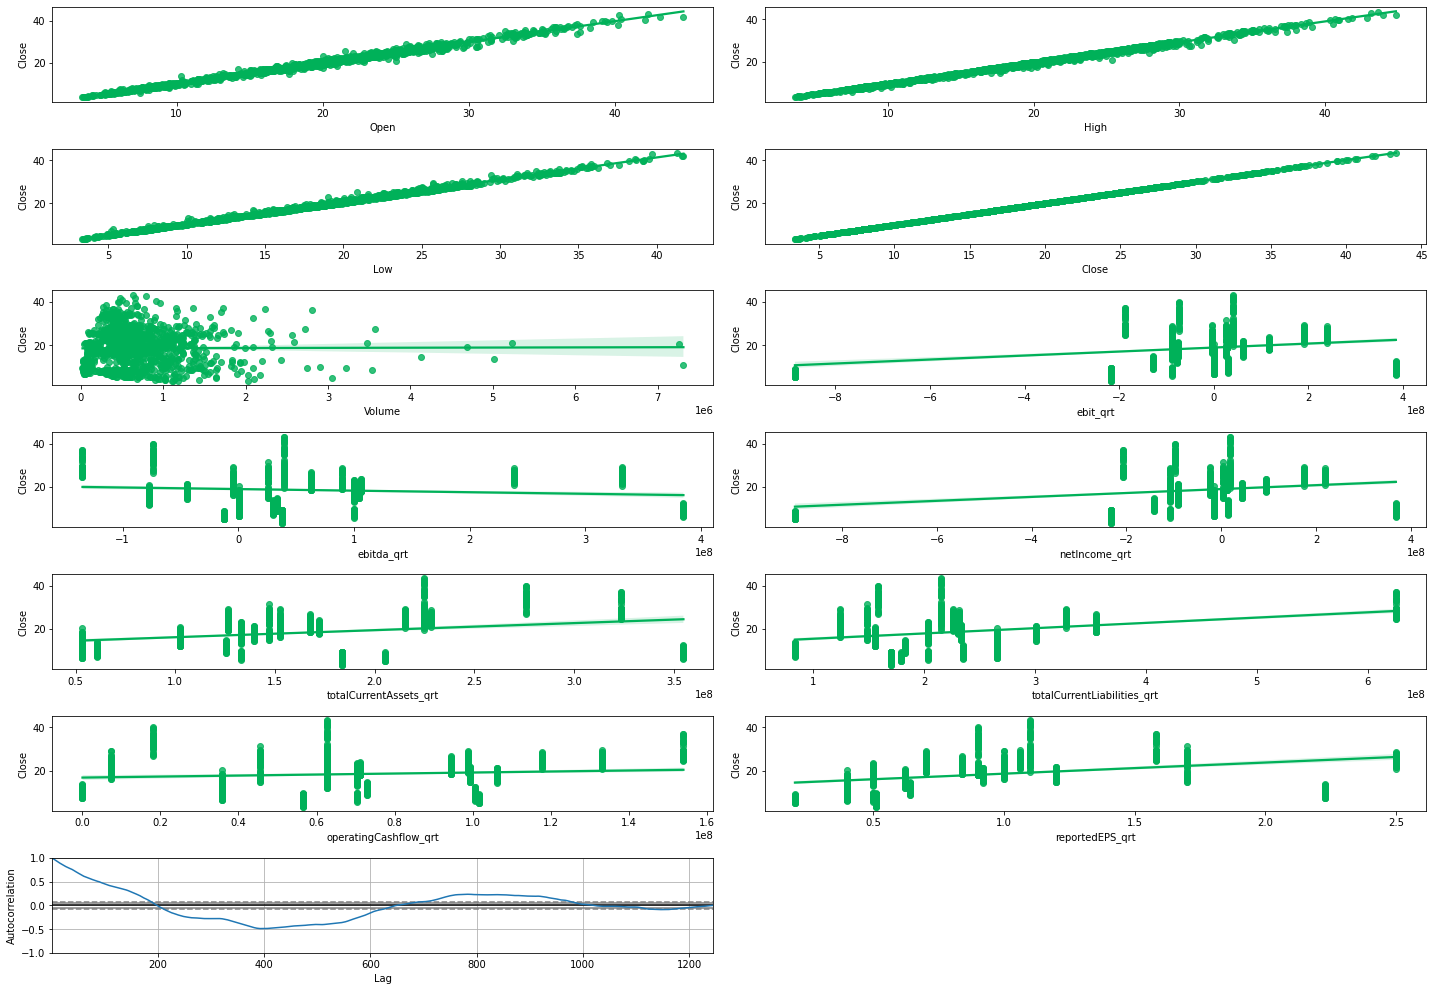

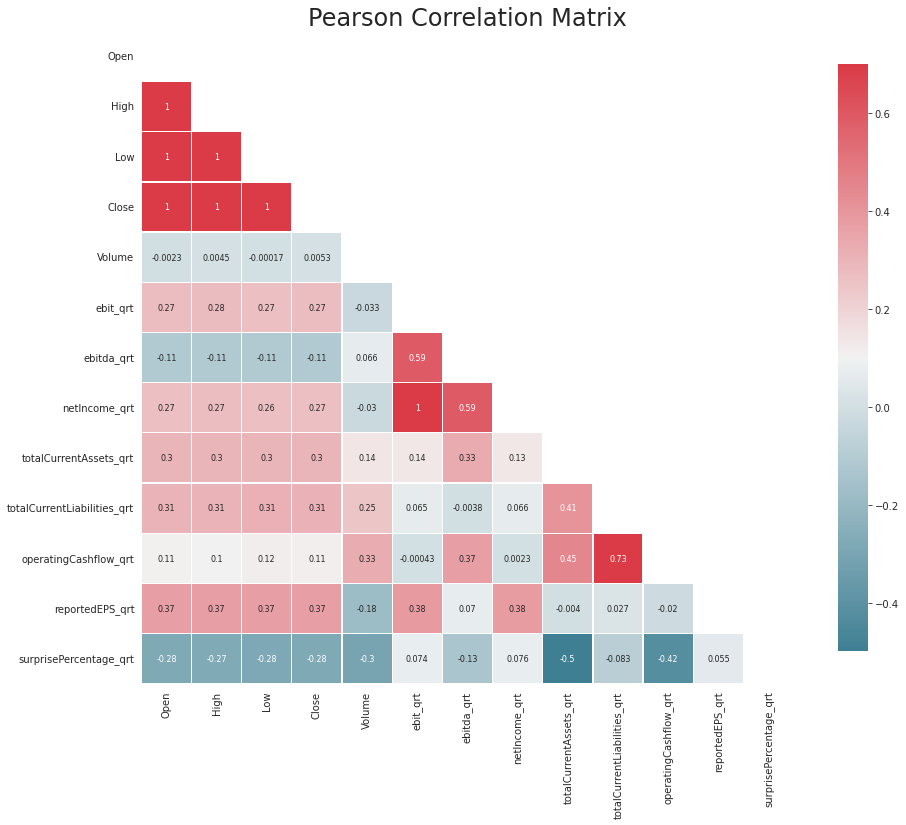

In [13]:
dataset = 'Dataset_medium' #@param ["Dataset_simple", "Dataset_medium", "Dataset_intraday"]
choose_stock = 'AAPL' #@param {type:"string"}
random_stock = True #@param {type:"boolean"}
show_plot_features = False #@param {type:"boolean"}
show_relation_with_target = True #@param {type:"boolean"}
show_autocorrelation = True #@param {type:"boolean"}
show_feature_correlation = True #@param {type:"boolean"}

dataset_symbols = get_available_symbols(dataset)

symbol_name = ""
stock_name = ""
showcase_df = None

if (random_stock):
  stock_number = randrange(len(dataset_symbols))
  symbol_name = dataset_symbols[stock_number]
  stock_name = symbol_name.split("/")[-1].replace(".csv","")
else:
  stock_name = choose_stock
  symbol_name = HOME_DIR+"/"+dataset+"/"+choose_stock+".csv"

if (dataset=='Dataset_simple'):
  try:
    showcase_df = get_simple_df(symbol_name)
  except:
    print("Dataset not found")
if (dataset=='Dataset_medium'):
  try:
    showcase_df = get_medium_df(symbol_name)
  except:
    print("Dataset not found")
if (dataset =='Dataset_intraday'):
  try:
    showcase_df = get_intraday_df(symbol_name)
  except:
    print("Dataset not found")


pandas_df = showcase_df.toPandas() 

features = list(pandas_df.columns.values)
features.remove("Date")

#show plots of the relation between target and other attributes
def relation_with_target():
  n_cols = 2
  n_rows = math.ceil(len(features)/n_cols)

  fig, axes = plt.subplots(n_rows, n_cols, figsize=(20,14))
  if (math.ceil(len(features)/n_cols) != len(features)/n_cols):
    fig.delaxes(axes[-1][-1])

  for i,f in enumerate(features):
    _ = sns.regplot(data=pandas_df, 
                    x=f, 
                    y="Close",
                    color="#00b159",
                    ax=axes[i//n_cols, i%n_cols])

  fig.tight_layout(pad=1.5)

#show plots of the features
def plot_features():
  for feature in features:
    fig = px.line(x="Date", y=feature, data_frame = pandas_df, title=stock_name+" "+feature+" over time")
    fig.update_xaxes(
        rangeslider_visible=True,
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1m", step="month", stepmode="backward"),
                dict(count=6, label="6m", step="month", stepmode="backward"),
                dict(count=1, label="YTD", step="year", stepmode="todate"),
                dict(count=1, label="1y", step="year", stepmode="backward"),
                dict(count=5, label="5y", step="year", stepmode="backward"),
                dict(step="all")
            ])
        )
    )
    fig.show()

#plots the autocorrelation with lag 1, and with other lags
def autocorrelation():
  
  import matplotlib.pyplot as pltlb
  data = pandas_df["Close"]
  print("Autocorrelation with lag 1: ",data.autocorr(lag=1), " (how much the value of a day affects the value of the next, maximum=1)")
  print()
  print("Autocorrelation wrt various lag")
  x = pd.plotting.autocorrelation_plot(data)
  x.plot()
  pltlb.show()

  
#plots correlation between features
def correlation_between_features():
  mask = np.zeros_like(pandas_df[features].corr(), dtype=bool) 
  mask[np.triu_indices_from(mask)] = True 

  with sns.axes_style("white"): 
    fig, ax = plt.subplots(figsize=(16, 12))
    plt.title('Pearson Correlation Matrix', fontsize=24)

    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    _ = sns.heatmap(pandas_df[features].corr(), 
                linewidths=0.25, 
                vmax=0.7, 
                square=True,
                ax=ax, 
                cmap=cmap, 
                linecolor='w', 
                annot=True, 
                annot_kws={"size":8}, 
                mask=mask, 
                cbar_kws={"shrink": .9});


print("** SHOWING PLOTS FOR $ "+ stock_name +" $ STOCK **")

if (show_relation_with_target):
  relation_with_target()

if (show_plot_features):
  plot_features()

if (show_autocorrelation):
  autocorrelation()

if (show_feature_correlation):
  correlation_between_features()


##The prediction task
We want to predict the variable "Close", i.e. the value of the stock price at the end of the market day. 

We saw earlier that due to autocorrelation, the past has an influence on the future, and in particular we saw that the autocorrelation had its max value with lag 1.
That's the reason why our task will be to predict the stock price of the next day. 

The stock price usually don't change that much between days, but since is possible to buy multiple stocks, it would still be very useful to sell those stocks at a slightly higher price.

##Features engineering

We have to transform the dataset in order for the model to take advantage of the data. 
* We lagged features (by 1 day), so that the model could use the previous day data as a feature to predict the closing price. 
* We computed the averaged features
* We computed the difference between days, so that the model could see how much this day is different from the past one in terms of features. 

I used this set of features (and omitted others like trend features) after conducting a brief test, that showed that they were the best combination.

In [ ]:
#given dataframe df, and a list of features, lags them by n_lags
def lag_features(df, n_lags, features):
  new_features = []
  mywindow = Window.orderBy("Date")

  for feature in features:
      lag_feature_name = feature+'_with_lag_'+str(n_lags)
      new_features.append(lag_feature_name)
      df = df.withColumn(lag_feature_name,lag(df[feature], n_lags).over(mywindow))
  return df, new_features

#given a dataframe and a list of features, adds a new feature
#with the average of the selected features
def average_features(df, features):
  new_features = []
  mywindow = Window.orderBy("Date")
  for feature in features:
    mov_avg_feature_name = feature+'_avg'
    new_features.append(mov_avg_feature_name)
    df = df.withColumn(mov_avg_feature_name,avg(df[feature]).over(mywindow))
  return df, new_features 

#return a dataframe with a new column with the differenced feature
def difference_features(df, features):
  new_features = []
  mywindow = Window.rowsBetween(-1, 0) # previous and current
  for feature in features:
    difference_feature_name = feature + "_differenced"
    new_features.append(difference_feature_name)
    df = df.withColumn(difference_feature_name, df[feature] -  func.first(df[feature]).over(mywindow))    
  return df, new_features

#pipeline that given a dataset and features, creates timeseries features:
#lagged values of the features
#rolling average
#differenced values
def build_features(df, features, prediction, LAG):

  new_features = []
  featured_df_temp, lagged_features = lag_features(df, LAG, features)
  new_features += lagged_features
  featured_df_temp, new_features_temp = difference_features(featured_df_temp, lagged_features)
  new_features += new_features_temp
  featured_df, new_features_temp = average_features(featured_df_temp, lagged_features)
  new_features += new_features_temp
  featured_df = featured_df.dropna()

  features_to_remove = set(featured_df.columns).difference(set(new_features))
  features_to_remove.discard(prediction)
  features_to_remove.discard("Date")
  for feature in list(features_to_remove):
    featured_df = featured_df.drop(feature)
  return featured_df, new_features

##Learning Pipeline
We arrived at the actual training phase. 
Our task clearly needs a regressor. The model chosen are:
* Linear Regressor
* Random Forest Regressor
* Gradient Boosted Tree Regressor
* Neural Network

Each of them will be trained for each stock.

Each of them save the results in the main memory, this will come in handy when we will do the testing phase, so that we don't have to do training each time. 

**Preprocessing pipeline**

Given a certain dataset with features want to be able to build a pipeline that preprocess it so that we can feed it to the model.

I left normalization optional because for some reason the model performed better without it, I think the big difference between the scale of the features could be the reason.

In [ ]:
N_LAGS = 1
SPLIT = 0.7

#return splitted dataframe 
def split_timeseries(df, split):
  df = df.withColumn("rank", percent_rank().over(Window.partitionBy().orderBy("Date")))
  train_df = df.where(df.rank <= split).drop("rank")
  test_df = df.where(df.rank > split).drop("rank")
  return train_df, test_df

#if drop_rate = 40, 40% of the rows starting from the beginning will be dropped
def drop_dataset_rows(df, drop_rate):
  n_rows = df.count()

  if (drop_rate==0):
    drop_rate = 0 
  else:
    drop_rate = drop_rate-1

  rows_to_drop = math.floor((drop_rate * n_rows)/100)
  df = df.withColumn("index", monotonically_increasing_id())
  df = df.where(col("index")>=rows_to_drop)
  df = df.drop("index")

  return df

#given features in input, assemble them and optionally normalize them
def preprocessing_pipeline(df, features, normalize):
  processed_df = None

  df = df.dropna()

  assembler = VectorAssembler(inputCols = features, outputCol="features", handleInvalid="skip")
  
  df_assembled = assembler.transform(df)

  processed_df = df_assembled.select(["Date","Close","features"])

  if (normalize):
    processed_df = processed_df.withColumnRenamed("features","Features")
    normalizer = Normalizer(inputCol="Features", outputCol="features", p=1.0)
    normalized_df = normalizer.transform(processed_df)
    processed_df = normalized_df.select(["Date","Close", "features"])
    return normalizer, processed_df.dropna()

  return processed_df

**Linear Regression**

Stock market isn't exactly linear, so I expect the model to have some flaws. However is a good start, and could perform well during the periods of linearity of the market. 

In [ ]:
#trains and test a linear regression model, given hyperparameters (maxIter, regParam, elasticNetParam) and features
#saves the model to a temporary folder and return the path of such folder
def linear_regression(df, features, N_LAGS, maxIter, regParam, elasticNetParam, drop_rate, normalized):
  SPLIT = 0.7

  df = drop_dataset_rows(df, drop_rate)
  df, features = build_features(df, features, "Close", N_LAGS)
  df_train, df_test = split_timeseries(df, SPLIT)


  normalizer = None
  if (normalized):
    normalizer, df_train = preprocessing_pipeline(df_train, features, normalize=True)
  else:
    df_train = preprocessing_pipeline(df_train, features, normalize=False)
    
  lr = LinearRegression(featuresCol="features", labelCol="Close", maxIter = maxIter, regParam = regParam, elasticNetParam = elasticNetParam)
  lr_model = lr.fit(df_train)
  #predictions_lr_train = lr_model.transform(df_train)
  #training_result = lr_model.summary
  
  df_test = preprocessing_pipeline(df_test, features, normalize=False)

  if (normalized):
    df_test = df_test.withColumnRenamed("features","Features")
    df_test = normalizer.transform(df_test)

  lr_test_predictions = lr_model.transform(df_test) 

  evaluator = RegressionEvaluator(labelCol="Close", predictionCol="prediction", metricName="rmse")
  RMSE = evaluator.evaluate(lr_test_predictions)
  evaluator = RegressionEvaluator(labelCol="Close", predictionCol="prediction", metricName="r2")
  R2 = evaluator.evaluate(lr_test_predictions)

  model_name = str(lr_model).replace(" ", "")
  model_name = model_name.translate({ord(i): None for i in '/=,:'})
  lr_model_path = HOME_DIR+"/lr_temp/"+ model_name
  lr_model.save(lr_model_path)
  """print("TEST SET RESULTS")
  print("RMSE:",RMSE)
  print("R2:",R2)"""
  return lr_model_path, model_name, RMSE, R2

**Random Forest Regression**

This model could have better performances due to its non linear nature. I think it is worth comparing it to linear regression. 

In [ ]:
#trains and test a random forest regression model, given hyperparameters (maxDepth, maxBins) and features
#saves the model to a temporary folder and return the path of such folder

def random_forest_regression(df, features, N_LAGS, maxDepth, maxBins, drop_rate, normalized):
  SPLIT = 0.7

  df = drop_dataset_rows(df, drop_rate)
  df, features = build_features(df, features, "Close", N_LAGS)
  df_train, df_test = split_timeseries(df, SPLIT)
  
  normalizer = None
  if (normalized):
    normalizer, df_train = preprocessing_pipeline(df_train, features, normalize=True)
  else:
    df_train = preprocessing_pipeline(df_train, features, normalize=False)
  
  rfr = RandomForestRegressor(featuresCol="features", labelCol="Close", maxDepth=maxDepth, maxBins=maxBins)
  rfr_model = rfr.fit(df_train)
  #predictions_rfr_train = rfr_model.transform(df_train)

  df_test = preprocessing_pipeline(df_test, features, normalize=False)
  if (normalized):
    df_test = df_test.withColumnRenamed("features","Features")
    df_test = normalizer.transform(df_test)

  rfr_test_predictions = rfr_model.transform(df_test) 

  evaluator = RegressionEvaluator(labelCol="Close", predictionCol="prediction", metricName="rmse")
  RMSE = evaluator.evaluate(rfr_test_predictions)
  evaluator = RegressionEvaluator(labelCol="Close", predictionCol="prediction", metricName="r2")
  R2 = evaluator.evaluate(rfr_test_predictions)
  
  model_name = str(rfr_model).replace(" ", "")
  model_name = model_name.translate({ord(i): None for i in '/=,:'})
  rfr_model_path = HOME_DIR+"/rfr_temp/"+ model_name
  rfr_model.save(rfr_model_path)

  """print("TEST SET RESULTS")
  print("RMSE:",RMSE)
  print("R2:",R2)"""

  return rfr_model_path, model_name, RMSE, R2


**Gradient Boosted Tree Regression**

Like random forests, gradient boosting is a set of decision trees. The two main differences are: How trees are built: random forests builds each tree independently while gradient boosting builds one tree at a time. 
The problem is that they tend to overfit, and I noticed they are much more slower than random forests, with the same performance, so we will discard them. 

In [ ]:
#trains and test a gradient boosted trees regression model, given hyperparameters (maxDepth, maxBins) and features
#saves the model to a temporary folder and return the path of such folder
def gradient_boosted_trees_regression(df, features, N_LAGS, maxIter, maxDepth, maxBins, drop_rate, normalized):
  SPLIT = 0.7

  df = drop_dataset_rows(df, drop_rate)
  df, features = build_features(df, features, "Close", N_LAGS)
  df_train, df_test = split_timeseries(df, SPLIT)
  
  normalizer = None
  if (normalized):
    normalizer, df_train = preprocessing_pipeline(df_train, features, normalize=True)
  else:
    df_train = preprocessing_pipeline(df_train, features, normalize=False)
  
  gbtr = GBTRegressor(featuresCol="features", labelCol="Close", seed=SEED, maxIter=maxIter, maxDepth=maxDepth, maxBins=maxBins)
  gbtr_model = gbtr.fit(df_train)
  predictions_gbtr_train = gbtr_model.transform(df_train)

  df_test = preprocessing_pipeline(df_test, features, normalize=False)
  if (normalized):
    df_test = df_test.withColumnRenamed("features","Features")
    df_test = normalizer.transform(df_test)

  gbtr_test_predictions = gbtr_model.transform(df_test) 

  evaluator = RegressionEvaluator(labelCol="Close", predictionCol="prediction", metricName="rmse")
  RMSE = evaluator.evaluate(gbtr_test_predictions)
  evaluator = RegressionEvaluator(labelCol="Close", predictionCol="prediction", metricName="r2")
  R2 = evaluator.evaluate(gbtr_test_predictions)
  
  model_name = str(gbt_model).replace(" ", "")
  model_name = model_name.translate({ord(i): None for i in '/=,:'})
  gbt_model_path = HOME_DIR+"/gbt_temp/"+ model_name
  gbt_model.save(gbt_model_path)

  """print("TEST SET RESULTS")
  print("RMSE:",RMSE)
  print("R2:",R2)"""


  return gbt_model, model_name, RMSE, R2


**Neural network**

Using SparkTorch, I built a neural network in order to have a more advanced model and see how it compared with more simpler models.
Unfortunately I was not able to make SparkTorch use a more complex neural network having LSMT and RNN, it seems like SparkTorch only works with sequential models.

Our model involves multiple linear layers, and a non linear activation function. (I used Elu because it can have negative values)

I discarded dropout because of the small size of the network (I also tried and the performaces degraded).
I'm not going to use the full dataset for 2 reason: I saw that the model is really sensible to the input. The difference between the size of the variables is high, and even with normalization the model perform worse using the full dataset, so we will limit ourselves to the simple dataset.

In [ ]:
def build_ML_dataset(df, features):
  df = drop_dataset_rows(df, drop_rate=10)
  features.remove("Volume")
  df, features = build_features(df, features, "Close", 1)
  df_train, df_test = split_timeseries(df, 0.7)
    
  df_train = preprocessing_pipeline(df_train, features, normalize=False)
  df_test = preprocessing_pipeline(df_test, features, normalize=False)

  return df_train, df_test, features


def neural_network_prediction(df, symbol):

  feat = df.columns
  feat.remove("Date")
  features = feat
  df_train, df_test, features = build_ML_dataset(df, features)

  input_dim = len(features)

  network = nn.Sequential(
      nn.Linear(input_dim, 128),
      nn.Linear(128, 128),
      nn.ELU(),
      nn.Linear(128, 32),
      nn.Linear(32, 1),
  )

  torch_obj = serialize_torch_obj(
      model=network,
      criterion=nn.MSELoss(),
      optimizer=torch.optim.Adam,
      lr=0.001
  )

  spark_model = SparkTorch(
      inputCol='features',
      labelCol='Close',
      predictionCol='prediction',
      torchObj=torch_obj,
      iters=600 # number of epochs
  )

  try:
    os.mkdir(HOME_DIR + "/nn_best")
  except:
    pass


  stock_name = symbol.split("/")[-1].replace(".csv","")
  model_name = HOME_DIR + "/nn_best/" + stock_name
  nn_pipeline = Pipeline(stages=[spark_model]).fit(df_train)
  nn_pipeline.write().overwrite().save(model_name)
  predictions = nn_pipeline.transform(df_test).persist()

  evaluator = RegressionEvaluator(labelCol="Close", predictionCol="prediction", metricName="rmse")
  RMSE = evaluator.evaluate(predictions)
  evaluator = RegressionEvaluator(labelCol="Close", predictionCol="prediction", metricName="r2")
  R2 = evaluator.evaluate(predictions)

  return model_name, RMSE, R2

## Hyperparameters tuning
Pypspark offers tools such as CrossValidator and TrainValidationSplit. 
They would simplify our life, but the problem is that we are working with time series and they function by randomly splitting the dataset. 

Of course we can't do that, so we have to build our own hyperparameters tuning, that will split the dataset in chronological order and try the best configuration for all the models. 

Among the parameters specific to the model (e.g. max_depth), I introduced a new one, called "drop_rate", that will discard a certain amount of the dataset so that old data will simply not be considered.

In [ ]:
#@title Have fun experimenting with regression hyperparameters
choose_stock = 'IBM' #@param {type:"string"}
regressor= 'linear_regression' #@param ["linear_regression", "random_forest_regression", "gradient_boosted_trees_regression"]
random_stock = False #@param {type:"boolean"}

dataset_symbols = get_available_symbols("Dataset_simple")

symbol_name = ""
stock_name = ""

if (random_stock):
  stock_number = randrange(len(dataset_symbols))
  symbol_name = dataset_symbols[stock_number]
  stock_name = symbol_name.split("/")[-1].replace(".csv","")
else:
  stock_name = choose_stock
  symbol_name = HOME_DIR+"/Dataset_simple"+"/"+choose_stock+".csv"

df = get_simple_df(symbol_name)

maxIter = 151 #@param {type:"slider", min:1, max:200, step:5}
regParam = 0.4 #@param {type:"slider", min:0, max:1, step:0.1}
elasticNetParam = 0.6 #@param {type:"slider", min:0, max:1, step:0.1}
drop_rate = 61 #@param {type:"slider", min:0, max:100, step:1}
n_lag = 1 #@param {type:"slider", min:1, max:50, step:1}
maxDepth = 5 #@param {type:"slider", min:1, max:5, step:1}
maxBins = 400 #@param {type:"slider", min:100, max:2000, step:100}
features = ["Close","Open", "High", "Low", "Volume"]

print("SHOWING REGRESSION FOR $- "+stock_name+" -$ STOCK")

if (regressor =='linear_regression'):
  try:
    _, _, RMSE, R2 = linear_regression(df, features, n_lag, maxIter, regParam, elasticNetParam, drop_rate, False)
    print("LINEAR REGRESSION RESULTS")
    print("RMSE:",RMSE)
    print("R2:",R2)
  except:
    raise Exception("Something wrong with regression")
if (regressor =='random_forest_regression'):
  try:
    _, _, RMSE, R2 = random_forest_regression(df, features, n_lag, maxDepth, maxBins, drop_rate, False)
    print("RANDOM FOREST REGRESSION RESULTS")
    print("RMSE:",RMSE)
    print("R2:",R2)
  except:
    raise Exception("Something wrong with regression")
if (regressor =='gradient_boosted_trees_regression'):
  try:
    _, _, RMSE, R2 = gradient_boosted_trees_regression(df, features, n_lag, maxIter, maxDepth, maxBins, drop_rate, False)
    print("GRADIENT BOOSTED TREE REGRESSION RESULTS")
    print("RMSE:",RMSE)
    print("R2:",R2)
  except:
    raise Exception("Something wrong with regression")

In [ ]:
#grid search of the best hyperparameters for linear regression
#(given in input as list of elements to try) returns the path of the best models
def hyperparameters_tuning_lr(df, features, maxIter, regParam, elasticNetParam, drop_rates, lags):
  hyperparameters = [float("inf"), None, None, None, None]

  for iter in maxIter:
    for reg in regParam:
      for enp in elasticNetParam:
        for drop_rate in drop_rates:
          for n_lag in lags:
            model_path, model_name, rmse, r2 = linear_regression(df, features, n_lag, iter, reg, enp, drop_rate, False)
            if (hyperparameters[0] > rmse):
              hyperparameters[0] = rmse
              hyperparameters[1] = model_path
              hyperparameters[2] = model_name
              hyperparameters[3] = (features, n_lag, iter, reg, enp, drop_rate)
              hyperparameters[4] = r2
              #print("New best values found:", hyperparameters[0],hyperparameters[2])
  
  best_model_path_temp = hyperparameters[1]
  best_model_name = hyperparameters[2]
  best_model_path = HOME_DIR+"/lr_best/"+best_model_name
  hyperparameters[1] = best_model_path
  shutil.copytree(best_model_path_temp, best_model_path)
  
  try:
    os.remove(HOME_DIR+"/lr_temp")
  except:
    print("remove directory operation not allowed")

  return hyperparameters

#grid search of the best hyperparameters for random forest regression
#(given in input as list of elements to try) returns the path of the best models
def hyperparameters_tuning_rfr(df, features, maxDepths, maxBins, drop_rates, lags):
  hyperparameters = [float("inf"), None, None, None, None]

  for bins in maxBins:
    for depth in maxDepths:
      for drop_rate in drop_rates:
        for n_lag in lags:
          model_path, model_name, rmse, r2 = random_forest_regression(df, features, n_lag, depth, bins, drop_rate, False)
          if (hyperparameters[0] > rmse):
            hyperparameters[0] = rmse
            hyperparameters[1] = model_path
            hyperparameters[2] = model_name
            hyperparameters[3] = (features, n_lag, depth, bins, drop_rate)
            hyperparameters[4] = r2
            #print("New best values found:", hyperparameters[0],hyperparameters[2])
  
  best_model_path_temp = hyperparameters[1]
  best_model_name = hyperparameters[2]
  best_model_path = HOME_DIR+"/rfr_best/"+best_model_name
  hyperparameters[1] = best_model_path
  shutil.copytree(best_model_path_temp, best_model_path)
  
  try:
    os.remove(HOME_DIR+"/rfr_temp")
  except:
    print("remove directory operation not allowed")

  return hyperparameters


## Testing the models
Using Google Colab tools, you can decide for which period you want to test the models.
I chose the period starting from 1/01/2020 to 1/05/2020. 

The reason is that I wanted to see how the model behaved during the COVID crisis, since the stock market was really unpredictable during that period.

Notice that here we're using RMSE, but there's a difference between a model overestimating and underestimating. I think underestimating could lead to a potential profit not fulfilled, but overestimating could lead to a loss. 

Anyway we will simply pick the best models in this way:
-select the n best models that have the lowest "score", where score is computed in this way:


```
score = RMSE / mean of the stock price
```
this is done because we are predicting stock with different values, and doing an error of 1\$ wrt a 2\$ stock is huge, wherease an error of 1\$ wrt to a 100\$ stock is a relatively small error.

Beware, we already did the training and validation using (hopefully) the best hyperparameters possible chosen by the tuning function. Now we will just use the already trained model to predict the price of the stocks during this difficult period.

In [ ]:
# @title Date fields
start_testing_interval = '2020-01-01' #@param {type:"date"}
end_testing_interval = '2020-05-01' #@param {type:"date"}

#split the original dataset in 2 part
# from the beginning to the start of the period of test
# from the start period of test to the end
def split_intervals(df, start, end):
  start = time.strptime(start_testing_interval, "%Y-%m-%d")
  end = time.strptime(end_testing_interval, "%Y-%m-%d")

  if (end <= start):
    raise Exception("End of the interval must be greater then start")

  df_pre_interval = df.where(col("Date")<start_testing_interval)
  df_interval = df.where((col("Date")>=start_testing_interval) & (col("Date")<=end_testing_interval))
  return df_pre_interval, df_interval

In [ ]:
#for every dataset, for every stock, test how well performs
# the linear regression, and save the actual Close value and the predicted one
def testing_lr():
  results = {}
  if (os.path.exists(HOME_DIR+"/lr_simple_medium_results.json")):
    with open(HOME_DIR+"/lr_simple_medium_results.json") as jsonFile:
      results = json.load(jsonFile)
      jsonFile.close()
  datasets = ["Dataset_simple", "Dataset_medium"]
  df = None
  maxIter = [25]
  regParam = [0.2, 0.4, 0.6, 0.8]
  elasticNetParam = [0.3, 0.5, 0.7]
  drop_rates = [0, 80]
  features = []
  lags = [1]
  for dataset_type in datasets:
    dataset_symbols = get_available_symbols(dataset_type)
    for symbol in sorted(dataset_symbols):
      symbol_splitted = symbol.split(HOME_DIR)
      symbol_key = "".join(symbol_splitted[-3:])
      if (symbol_key not in results):
        if (dataset_type == "Dataset_simple"):
          df = get_simple_df(symbol)
          feat = df.columns
          feat.remove("Date")
          features = feat
        if (dataset_type == "Dataset_medium"):
          df = get_medium_df(symbol)
          feat = df.columns
          feat.remove("Date")
          features = feat
        
        df_pre_interval, df_interval = split_intervals(df, start_testing_interval, end_testing_interval)
        old_RMSE, regression_model_path, regression_model_name, hyperparameters, old_R2 = hyperparameters_tuning_lr(df_pre_interval, features, maxIter, regParam, elasticNetParam, drop_rates, lags)
        regression_model = LinearRegressionModel.load(regression_model_path)
        
        df_interval, features = build_features(df_interval, features, "Close", N_LAGS)
        df_interval = preprocessing_pipeline(df_interval, features, normalize=False)

        lr_interval_prediction = regression_model.transform(df_interval) 
        
        evaluator = RegressionEvaluator(labelCol="Close", predictionCol="prediction", metricName="rmse")
        RMSE = evaluator.evaluate(lr_interval_prediction)
        evaluator = RegressionEvaluator(labelCol="Close", predictionCol="prediction", metricName="r2")
        R2 = evaluator.evaluate(lr_interval_prediction)
        
        array_avg = df_interval.select(avg("Close")).collect()[0]
        close_avg = float(str(array_avg).split("=")[-1].replace(")", ""))
        score = RMSE/close_avg

        
        stock_name = symbol.split("/")[-1].replace(".csv","")
        try:
          os.mkdir(HOME_DIR+"/test_simple_medium_lr")
        except:
          pass
        lr_interval_prediction = lr_interval_prediction.select(["Date", "Close", "prediction"])
        save_stock_csv_path = HOME_DIR+"/test_simple_medium_lr/"+stock_name+ "_" +dataset_type +".csv"
        stock_csv_path = "/test_simple_medium_lr/"+stock_name+"_" +dataset_type+ ".csv"
        lr_interval_prediction.toPandas().to_csv(save_stock_csv_path)
        
        print("Stock:", stock_name, "Score: ", score, "RMSE and R2: ", (RMSE,R2), "old RMSE and R2: ", (old_RMSE, old_R2), "Hyperparameters: ", hyperparameters)
        results[symbol_key] = ["/lr_best/"+regression_model_name, stock_csv_path, (RMSE, R2), (old_RMSE, old_R2), score]
        with open(HOME_DIR+"/lr_simple_medium_results.json", "w") as f:
          json.dump(results, f)

#for every dataset, for every stock, test how well performs
# the random forest regression, and save the actual Close value and the predicted one
def testing_rfr():
  results = {}
  if (os.path.exists(HOME_DIR+"/rfr_simple_medium_results.json")):
    with open(HOME_DIR+"/rfr_simple_medium_results.json") as jsonFile:
      results = json.load(jsonFile)
      jsonFile.close()
  datasets = ["Dataset_simple", "Dataset_medium"]
  df = None
  
  maxDepths = [3,5,7]
  maxBins = [300, 600, 1200]
  drop_rates = [0, 80]
  features = []
  lags = [1]
  for dataset_type in datasets:
    dataset_symbols = get_available_symbols(dataset_type)
    for symbol in sorted(dataset_symbols):
      symbol_splitted = symbol.split(HOME_DIR)
      symbol_key = "".join(symbol_splitted[-3:])
      if (symbol_key not in results):
        if (dataset_type == "Dataset_simple"):
          df = get_simple_df(symbol)
          feat = df.columns
          feat.remove("Date")
          features = feat
        if (dataset_type == "Dataset_medium"):
          df = get_medium_df(symbol)
          feat = df.columns
          feat.remove("Date")
          features = feat
        
        df_pre_interval, df_interval = split_intervals(df, start_testing_interval, end_testing_interval)

        old_RMSE, regression_model_path, regression_model_name, hyperparameters, old_R2 = hyperparameters_tuning_rfr(df, features, maxDepths, maxBins, drop_rates, lags)

        regression_model = RandomForestRegressionModel.load(regression_model_path)
        
        df_interval, features = build_features(df_interval, features, "Close", N_LAGS)
        df_interval = preprocessing_pipeline(df_interval, features, normalize=False)

        rfr_interval_prediction = regression_model.transform(df_interval) 
        
        evaluator = RegressionEvaluator(labelCol="Close", predictionCol="prediction", metricName="rmse")
        RMSE = evaluator.evaluate(rfr_interval_prediction)
        evaluator = RegressionEvaluator(labelCol="Close", predictionCol="prediction", metricName="r2")
        R2 = evaluator.evaluate(rfr_interval_prediction)
        
        array_avg = df_interval.select(avg("Close")).collect()[0]
        close_avg = float(str(array_avg).split("=")[-1].replace(")", ""))
        score = RMSE/close_avg

        
        stock_name = symbol.split("/")[-1].replace(".csv","")
        try:
          os.mkdir(HOME_DIR+"/test_simple_medium_rfr")
        except:
          pass
        rfr_interval_prediction = rfr_interval_prediction.select(["Date", "Close", "prediction"])
        save_stock_csv_path = HOME_DIR+"/test_simple_medium_rfr/"+stock_name + "_" +dataset_type +".csv"
        stock_csv_path = "/test_simple_medium_rfr/"+stock_name + "_" +dataset_type +".csv"
        rfr_interval_prediction.toPandas().to_csv(save_stock_csv_path)
        
        print("Stock:", stock_name, "Score: ", score, "RMSE and R2: ", (RMSE,R2), "old RMSE and R2: ", (old_RMSE, old_R2))
        results[symbol_key] = ["/rfr_best/"+regression_model_name, stock_csv_path, (RMSE, R2), (old_RMSE, old_R2), score]
        with open(HOME_DIR+"/rfr_simple_medium_results.json", "w") as f:
          json.dump(results, f)


In [ ]:
def testing_intraday():
  results = {}
  if (os.path.exists(HOME_DIR+"/lr_intraday_results.json")):
    with open(HOME_DIR+"/lr_intraday_results.json") as jsonFile:
      results = json.load(jsonFile)
      jsonFile.close()
  datasets = ["Dataset_intraday"]
  df = None
  maxIter = [25]
  regParam = [0.2, 0.4, 0.6, 0.8]
  elasticNetParam = [0.3, 0.5, 0.7]
  drop_rates = [0, 80]
  features = []
  lags = [1]

  maxDepths = [3,5,7]
  maxBins = [300, 600, 1200]
  drop_rates = [0, 80]

  for dataset_type in datasets:
    dataset_symbols = get_available_symbols(dataset_type)
    for symbol in sorted(dataset_symbols):
      symbol_splitted = symbol.split(HOME_DIR)
      symbol_key = "".join(symbol_splitted[-3:])
      if (symbol_key not in results):
        df = get_intraday_df(symbol)
        feat = df.columns
        feat.remove("Date")
        features = feat
        
        df_pre_interval, df_interval = split_intervals(df, start_testing_interval, end_testing_interval)
        old_RMSE, regression_model_path, regression_model_name, hyperparameters, old_R2 = hyperparameters_tuning_lr(df_pre_interval, features, maxIter, regParam, elasticNetParam, drop_rates, lags)
        regression_model = LinearRegressionModel.load(regression_model_path)
        
        df_interval, features = build_features(df_interval, features, "Close", N_LAGS)
        df_interval = preprocessing_pipeline(df_interval, features, normalize=False)

        lr_interval_prediction = regression_model.transform(df_interval) 
        
        evaluator = RegressionEvaluator(labelCol="Close", predictionCol="prediction", metricName="rmse")
        RMSE = evaluator.evaluate(lr_interval_prediction)
        evaluator = RegressionEvaluator(labelCol="Close", predictionCol="prediction", metricName="r2")
        R2 = evaluator.evaluate(lr_interval_prediction)
        
        array_avg = df_interval.select(avg("Close")).collect()[0]
        close_avg = float(str(array_avg).split("=")[-1].replace(")", ""))
        score = RMSE/close_avg

        
        stock_name = symbol.split("/")[-1].replace(".csv","")
        try:
          os.mkdir(HOME_DIR+"/test_intraday_lr")
        except:
          pass
        lr_interval_prediction = lr_interval_prediction.select(["Date", "Close", "prediction"])
        save_stock_csv_path = HOME_DIR+"/test_intraday_lr/"+stock_name+ "_" +dataset_type +".csv"
        stock_csv_path = "/test_intraday_lr/"+stock_name+"_" +dataset_type+ ".csv"
        lr_interval_prediction.toPandas().to_csv(save_stock_csv_path)
        
        print("Stock:", stock_name, "Score: ", score, "RMSE and R2: ", (RMSE,R2), "old RMSE and R2: ", (old_RMSE, old_R2), "Hyperparameters: ", hyperparameters)
        results[symbol_key] = ["/intraday_lr_best/"+regression_model_name, stock_csv_path, (RMSE, R2), (old_RMSE, old_R2), score]
        with open(HOME_DIR+"/lr_intraday_results.json", "w") as f:
          json.dump(results, f)

        
        df = get_intraday_df(symbol)
        feat = df.columns
        feat.remove("Date")
        features = feat
        df_pre_interval, df_interval = split_intervals(df, start_testing_interval, end_testing_interval)

        old_RMSE, regression_model_path, regression_model_name, hyperparameters, old_R2 = hyperparameters_tuning_rfr(df, features, maxDepths, maxBins, drop_rates, lags)

        regression_model = RandomForestRegressionModel.load(regression_model_path)
        
        df_interval, features = build_features(df_interval, features, "Close", N_LAGS)
        df_interval = preprocessing_pipeline(df_interval, features, normalize=False)

        rfr_interval_prediction = regression_model.transform(df_interval) 
        
        evaluator = RegressionEvaluator(labelCol="Close", predictionCol="prediction", metricName="rmse")
        RMSE = evaluator.evaluate(rfr_interval_prediction)
        evaluator = RegressionEvaluator(labelCol="Close", predictionCol="prediction", metricName="r2")
        R2 = evaluator.evaluate(rfr_interval_prediction)
        
        array_avg = df_interval.select(avg("Close")).collect()[0]
        close_avg = float(str(array_avg).split("=")[-1].replace(")", ""))
        score = RMSE/close_avg

        
        stock_name = symbol.split("/")[-1].replace(".csv","")
        try:
          os.mkdir(HOME_DIR+"/test_intraday_rfr")
        except:
          pass
        rfr_interval_prediction = rfr_interval_prediction.select(["Date", "Close", "prediction"])
        save_stock_csv_path = HOME_DIR+"/test_intraday_rfr/"+stock_name + "_" +dataset_type +".csv"
        stock_csv_path = "/test_intraday_rfr/"+stock_name + "_" +dataset_type +".csv"
        rfr_interval_prediction.toPandas().to_csv(save_stock_csv_path)
        
        print("Stock:", stock_name, "Score: ", score, "RMSE and R2: ", (RMSE,R2), "old RMSE and R2: ", (old_RMSE, old_R2))
        results[symbol_key] = ["/intraday_rfr_best/"+regression_model_name, stock_csv_path, (RMSE, R2), (old_RMSE, old_R2), score]
        with open(HOME_DIR+"/rfr_intraday_results.json", "w") as f:
          json.dump(results, f)

In [ ]:
def testing_nn():
  results = {}
  if (os.path.exists(HOME_DIR+"/nn_simple_results.json")):
    with open(HOME_DIR+"/nn_simple_results.json") as jsonFile:
      results = json.load(jsonFile)
      jsonFile.close()
  datasets = ["Dataset_simple"]
  df = None

  for dataset_type in datasets:
    dataset_symbols = get_available_symbols(dataset_type)
    for symbol in sorted(dataset_symbols):
      symbol_splitted = symbol.split(HOME_DIR)
      symbol_key = "".join(symbol_splitted[-3:])
      if (symbol_key not in results):
        df = get_simple_df(symbol)
        feat = df.columns
        feat.remove("Date")
        features = feat
        
        df_pre_interval, df_interval = split_intervals(df, start_testing_interval, end_testing_interval)
        model_name, old_RMSE, old_R2 = neural_network_prediction(df_pre_interval, symbol)
        regression_model = PysparkPipelineWrapper.unwrap(PipelineModel.load(model_name))
        feat = df_interval.columns
        feat.remove("Date")
        features = feat
        features.remove("Volume")
        df_interval, features = build_features(df_interval, features, "Close", 1)
        df_interval = preprocessing_pipeline(df_interval, features, normalize=False)
  
        predictions = regression_model.transform(df_interval).persist()
        
        evaluator = RegressionEvaluator(labelCol="Close", predictionCol="prediction", metricName="rmse")
        RMSE = evaluator.evaluate(predictions)
        evaluator = RegressionEvaluator(labelCol="Close", predictionCol="prediction", metricName="r2")
        R2 = evaluator.evaluate(predictions)
        
        array_avg = df_interval.select(avg("Close")).collect()[0]
        close_avg = float(str(array_avg).split("=")[-1].replace(")", ""))
        score = RMSE/close_avg
        
        stock_name = symbol.split("/")[-1].replace(".csv","")
        try:
          os.mkdir(HOME_DIR+"/test_simple_nn")
        except:
          pass
        predictions = predictions.select(["Date", "Close", "prediction"])
        save_stock_csv_path = HOME_DIR+"/test_simple_nn/"+stock_name+ "_" +dataset_type +".csv"
        stock_csv_path = "/test_simple_nn/"+stock_name+"_" +dataset_type+ ".csv"
        predictions.toPandas().to_csv(save_stock_csv_path)
        
        print("Stock:", stock_name, "Score: ", score, "RMSE and R2: ", (RMSE,R2), "old RMSE and R2: ", (old_RMSE, old_R2))
        results[symbol_key] = [model_name, stock_csv_path, (RMSE, R2), (old_RMSE, old_R2), score]
        with open(HOME_DIR+"/nn_simple_results.json", "w") as f:
          json.dump(results, f)

In [ ]:
if (not DOWNLOAD):
  testing_lr()
  testing_rfr()
  testing_intraday()
  testing_nn()
else:
  RESULTS_LINK = "https://github.com/itsbenigno/stock_market_predictions_pyspark/raw/main/test_results.zip"
  urllib.request.urlretrieve(RESULTS_LINK, HOME_DIR+"/test_results.zip")
  with zipfile.ZipFile(HOME_DIR+"/test_results.zip", 'r') as zip_ref:
    zip_ref.extractall(HOME_DIR)

##Plotting results

Now we can see visually the performance of our models.

We are using RMSE, R2 and score to compare the different models. 
We select the best model with the highest R2 and lowest (so better) score.

As usual you can configure the comparison between models using Google Colabs sliders etc.

Beware, the model trained on the intraday data (both linear and random forest regression) obviously cannot be compared to the others, since the task is different (predicting the next 30 minutes vs predicting the next day) and the difference in price is much smaller (and consequently the error commited in the prediction).

The overall score gives us a good idea of how the model performs. 
Also I think plotting the predicted and the actual price is really useful, because you can see if the model is optimistic or pessimistic in its prevision.
From what I can see, the model is overoptimistic, and I think is due to the fact that it has been trained before the Covid crisis. 

In [9]:
#@title Choose the models you want to compare
first_model = 'linear_regression' #@param ["linear_regression", "random_forest_regression", "neural_network", "linear_regression_intraday", "random_forest_intraday"]
second_model = 'neural_network' #@param ["linear_regression", "random_forest_regression", "neural_network", "linear_regression_intraday", "random_forest_intraday"]
number_of_best_stocks = 3 #@param {type:"slider", min:1, max:20, step:1}

if (first_model == second_model):
  raise Exception("First model must be different from the second one")

#load the results of the test, and select the n_best prediction (computed given the score)
def select_best_score(json_path, n_best):
  results = {}
  list_result = []
  with open(HOME_DIR+"/"+json_path) as jsonFile:
    results = json.load(jsonFile)
    jsonFile.close()
  for symbol_name in results:
    final_result = results[symbol_name]
    final_result.append(symbol_name)
    list_result.append(final_result)
  list_result = sorted(list_result, key=lambda i: (i[-2])) #bigger R2 and smaller error
  return list_result[:n_best]

first_best_scores = None
second_best_scores = None

if (first_model == "linear_regression"):
  first_best_scores = select_best_score("lr_simple_medium_results.json", number_of_best_stocks)
if (first_model == "random_forest_regression"):
  first_best_scores = select_best_score("rfr_simple_medium_results.json", number_of_best_stocks)
if (first_model == "neural_network"):
  first_best_scores = select_best_score("nn_simple_results.json", number_of_best_stocks)
if (first_model == "linear_regression_intraday"):
  first_best_scores = select_best_score("lr_intraday_results.json", number_of_best_stocks)
if (first_model == "random_forest_intraday"):
  first_best_scores = select_best_score("rfr_intraday_results.json", number_of_best_stocks)

if (second_model == "linear_regression"):
  second_best_scores = select_best_score("lr_simple_medium_results.json", number_of_best_stocks)
if (second_model == "random_forest_regression"):
  second_best_scores = select_best_score("rfr_simple_medium_results.json", number_of_best_stocks)
if (second_model == "neural_network"):
  second_best_scores = select_best_score("nn_simple_results.json", number_of_best_stocks)
if (second_model == "linear_regression_intraday"):
  second_best_scores = select_best_score("lr_intraday_results.json", number_of_best_stocks)
if (second_model == "random_forest_intraday"):
  second_best_scores = select_best_score("rfr_intraday_results.json", number_of_best_stocks)


#given a dataframe, plot the prediction and the actual value
def plot_result(df):
  fig = px.line(x="Date", y=df.columns, data_frame = df, title="Predictions vs Reality")
  fig.update_xaxes(
      rangeslider_visible=True,
      rangeselector=dict(
          buttons=list([
              dict(count=1, label="1m", step="month", stepmode="backward"),
              dict(count=6, label="6m", step="month", stepmode="backward"),
              dict(count=1, label="YTD", step="year", stepmode="todate"),
              dict(count=1, label="1y", step="year", stepmode="backward"),
              dict(count=5, label="5y", step="year", stepmode="backward"),
              dict(step="all")
          ])
      )
  )
  fig.show()

def plot_results(best_scores):
  for score in best_scores:
    df_path = HOME_DIR + score[1]
    dataset = spark.read.load(df_path, format="csv", sep=",", inferSchema="true", header="true")
    dataset = dataset.drop('_c0')
    pandas_df = dataset.toPandas() 
    _, dataset, stock = score[-1].split("/")

    print("Stock:", stock, " Dataset used:", dataset)
    print("Overall score (RMSE / mean of the stock price):", score[-2])
    print("RMSE and R2 during validation", score[3])
    print("RMSE and R2 during testing", score[2])
    plot_result(pandas_df)

print("** SHOWING ", first_model, " RESULTS **")
plot_results(first_best_scores)
print("** SHOWING ", second_model, " RESULTS **")
plot_results(second_best_scores)

** SHOWING  linear_regression  RESULTS **
Stock: HPK.csv  Dataset used: Dataset_medium
Overall score (RMSE / mean of the stock price): 0.016512007516311062
RMSE and R2 during validation [0.08586894536929147, -3.7000066921752977]
RMSE and R2 during testing [0.17225930338851672, -10.096400808448129]


Stock: BMY.csv  Dataset used: Dataset_simple
Overall score (RMSE / mean of the stock price): 0.02463690663810394
RMSE and R2 during validation [0.9447388966552719, 0.9658639720759234]
RMSE and R2 during testing [1.494225388808746, 0.9210501119923683]


Stock: CERN.csv  Dataset used: Dataset_simple
Overall score (RMSE / mean of the stock price): 0.025189805131746103
RMSE and R2 during validation [1.0065061331783676, 0.9791005034132253]
RMSE and R2 during testing [1.7686192252842645, 0.9114694475954856]


** SHOWING  neural_network  RESULTS **
Stock: SLGN.csv  Dataset used: Dataset_simple
Overall score (RMSE / mean of the stock price): 0.026347283394850565
RMSE and R2 during validation [0.33663871157678216, 0.9757052297344057]
RMSE and R2 during testing [0.8091475639966302, 0.8641319382598396]


Stock: EXPD.csv  Dataset used: Dataset_simple
Overall score (RMSE / mean of the stock price): 0.026521773620735184
RMSE and R2 during validation [0.8020505869483107, 0.9952928546721952]
RMSE and R2 during testing [1.8805845709603992, 0.8637578171482454]


Stock: PFE.csv  Dataset used: Dataset_simple
Overall score (RMSE / mean of the stock price): 0.02654890823421547
RMSE and R2 during validation [0.4884061741088252, 0.9837356595725222]
RMSE and R2 during testing [0.9024318837405891, 0.9038151357520334]


In [ ]:
#@title Are the financial indicators helping the prediction?
choose_stock = 'A' #@param {type:"string"}
regressor = 'linear_regression' #@param ["linear_regression", "random_forest_regression"]

json_path = ""

if (regressor == "linear_regression"):
  json_path = "lr_simple_medium_results.json"
else:
  json_path = "rfr_simple_medium_results.json"

results = {}
list_result = []
with open(HOME_DIR+"/"+json_path) as jsonFile:
  results = json.load(jsonFile)
  jsonFile.close()
  symbol_name_simple = "/Dataset_simple/" + choose_stock + ".csv"
  symbol_name_medium = "/Dataset_medium/" + choose_stock + ".csv"
  final_result = results[symbol_name_simple]
  final_result.append(symbol_name_simple)
  list_result.append(final_result)
  final_result = results[symbol_name_medium]
  final_result.append(symbol_name_medium)
  list_result.append(final_result)
  
plot_results(list_result)


Stock: A.csv  Dataset used: Dataset_simple
Overall score (RMSE / mean of the stock price): 0.03310119265224357
RMSE and R2 during validation [0.9487873592809495, 0.9956785895029271]
RMSE and R2 during testing [2.6131130940883933, 0.868452769796286]


Stock: A.csv  Dataset used: Dataset_medium
Overall score (RMSE / mean of the stock price): 0.030414312916507827
RMSE and R2 during validation [1.2133540196557127, 0.9380540908341781]
RMSE and R2 during testing [2.4010022890955116, 0.8889418476024956]


##Conclusion

The first thing that I notice during the test, is that the more we are try to do a prediction far away from the training test (e.g. we train from 2005 to 2010, and we use the model to predict 2011) the more the model is wrong.

This is a problem intrinsic with the stock market, since it's basically impossible to generalize correctly, because there could be some (abrupt) changes that are not foreseeable (for example COVID crisis altered the trend of many companies).

So I learned that the best thing to do the training of the model as close as possible to the date we want to predict (I don't think is feasible to train every day for each stock with my current setup, but maybe once every 3/4 days)

Predicting the next day revealed to be a good idea since the autocorrelation is maximum and is more easy for the model to predict just a day.

The hyperparameters really made a difference with linear and random forest regression. They slowed the training phase, but helped gave great results.

Looking at the results, I think random forest regression did the best job. 
Following there was the neural network, that did a better job generalizing for more time. Linear regression did the worse, but it's reasonable considering that the market, especially in that time was higly non-linear.

The using of financial features helped the prediction in some cases, but in others did worse, maybe a more complex network could benefit more from them, anyway a think it's more feasible to just use the standard parameters provided by Yahoo finance, especially considering real time predictions.

It was a pity that SparkTorch only supported sequential models, because that really limited how the network performed. At the same time it was impressive to see such good results for such a small network. However I think that a bigger network doesn't automatically mean better performances, and needs much more attention to perform better than a small network (i.e. you can't just add layers and hope to have a better model).
Our neural network was really sensible to the high difference between features (even with normalization applied), contrary to random forest and linear regression.  

It would be interesting to:
- create a more sophisticated neural network (using LSMT and RNN)
- give more attention to intraday predictions
- implementing an actual program to do live prediction

